In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv("avocado.csv")

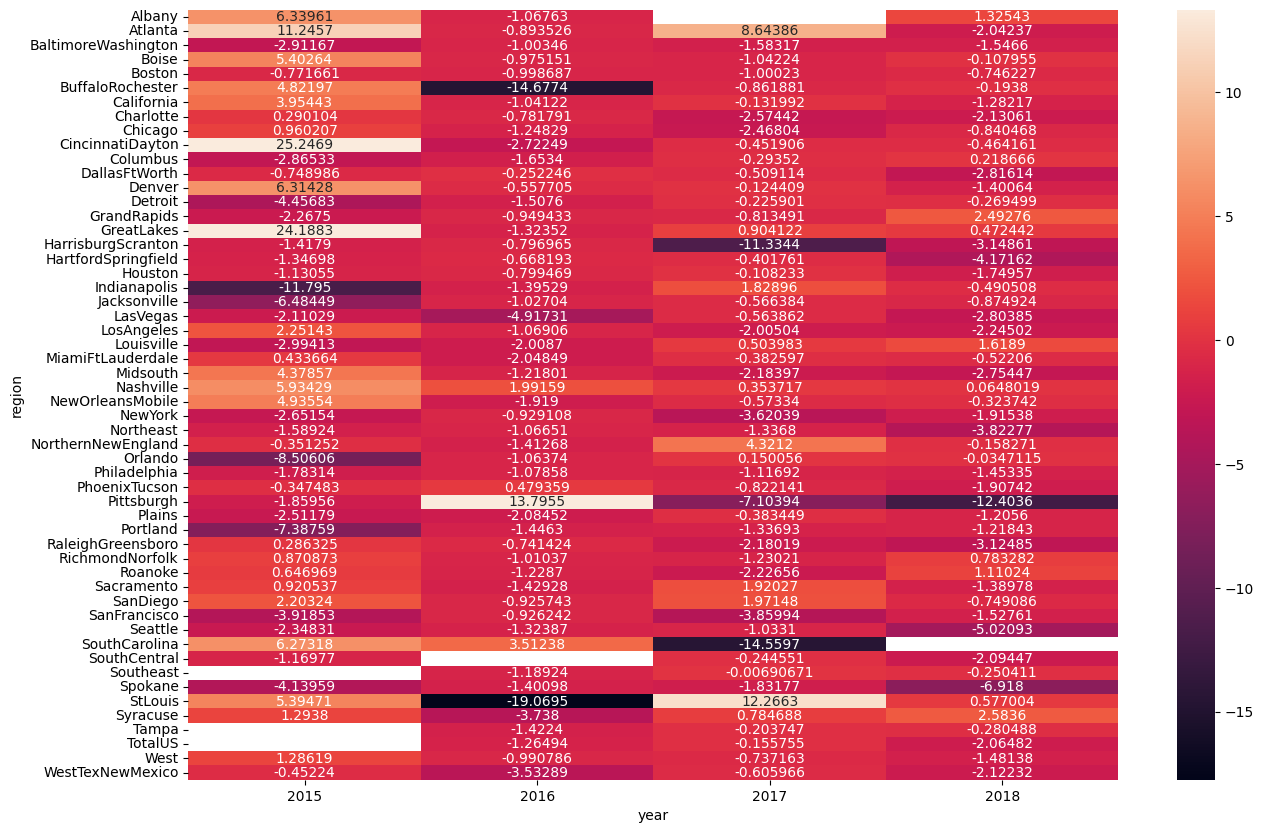

level_0  index  Total Volume_max  Avg_max  year   Date_max  \
0       2754      0          64236.62     1.33  2015 2015-12-27   
1       2755     52         386100.49     0.99  2015 2015-12-27   
2       2756    104         596819.40     1.17  2015 2015-12-27   
3       2757    156          62909.69     0.97  2015 2015-12-27   
4       2758    208         450816.39     1.13  2015 2015-12-27   
..       ...    ...               ...      ...   ...        ...   
211     9121   9066          93961.48     1.38  2018 2018-03-25   
212     9122   9078         469300.74     1.33  2018 2018-03-25   
213     9123   9090       43409835.75     1.03  2018 2018-03-25   
214     9124   9102        7667064.46     0.93  2018 2018-03-25   
215     9125   9114         965185.06     0.84  2018 2018-03-25   

                  region          type   Date_min  Avg_min  Total Volume_min  \
0                 Albany  conventional 2015-01-04     1.22          40873.28   
1                Atlanta  conventional 2015-01-04     1.00         435021.49   
2    BaltimoreWashington  conventional 2015-01-04     1.08         788025.06   
3                  Boise  conventional 2015-01-04     1.01          80034.32   
4                 Boston  conventional 2015-01-04     1.02         491738.00   
..                   ...           ...        ...      ...               ...   
211             Syracuse  conventional 2018-01-07     1.21          68938.02   
212                Tampa  conventional 2018-01-07     1.20         484007.91   
213              TotalUS  conventional 2018-01-07     1.13       36703156.72   
214                 West  conventional 2018-01-07     1.08        6358768.95   
215     WestTexNewMexico  conventional 2018-01-07     0.88         880266.52   

     Elasticidad  
0       6.339611  
1      11.245651  
2      -2.911669  
3       5.402644  
4      -0.771661  
..           ...  
211     2.583598  
212    -0.280488  
213    -2.064822  
214    -1.481376  
215    -2.122321  

[216 rows x 12 columns]

In [3]:
#Elasticidad Precio-Demanda por Año

"""
Aquí añado las columnas de region y tipo de aguacate (normal y organico) para hacer varios analisis por region
"""

df_elast=df.loc[:,["Total Volume","AveragePrice","year","Date","region","type"]]
df_elast["Date"]=pd.to_datetime(df_elast["Date"])



df_orden=df_elast.sort_values(by=['Date', "region"])

#aguacate convencional anual

"""
hago a mano la tabla para trabajar de forma anual con los guacates y calcular elasticidad para acabar haciendo un heatmap
"""


conventional=df_orden.loc[df_orden['type'] == "conventional"].reset_index()

val_max_con=conventional.loc[conventional.groupby(by=["year","region"])["Date"].idxmax()].reset_index()
val_max_con.rename({"Date": "Date_max", "AveragePrice": "Avg_max", "Total Volume":"Total Volume_max"}, inplace=True, axis=1)

val_min_con=conventional.loc[conventional.groupby(by=["year","region"])["Date"].idxmin()].reset_index()
val_min_con.rename({"Date": "Date_min", "AveragePrice": "Avg_min", "Total Volume":"Total Volume_min"},inplace=True, axis=1)


min_max_con=pd.concat([val_max_con,val_min_con["Date_min"], val_min_con["Avg_min"], val_min_con["Total Volume_min"]], axis=1)


#min_max["Total Volume_max"]==min_max["Total Volume_min"]

val_min_con
min_max_con["Elasticidad"]=((min_max_con["Total Volume_max"]-min_max_con["Total Volume_min"])/min_max_con["Total Volume_min"])/((min_max_con["Avg_max"]-min_max_con["Avg_min"])/min_max_con["Avg_min"])

"""
Una vez hecha esta tabla se hace un heatmap para encontrar valores anómalos
"""
plt.figure(figsize=(15,10))
heat_min_max_con=min_max_con.pivot(index="region", columns="year", values="Elasticidad")

sns.heatmap(heat_min_max_con, annot=True, fmt="g", robust=True)
plt.show()

min_max_con

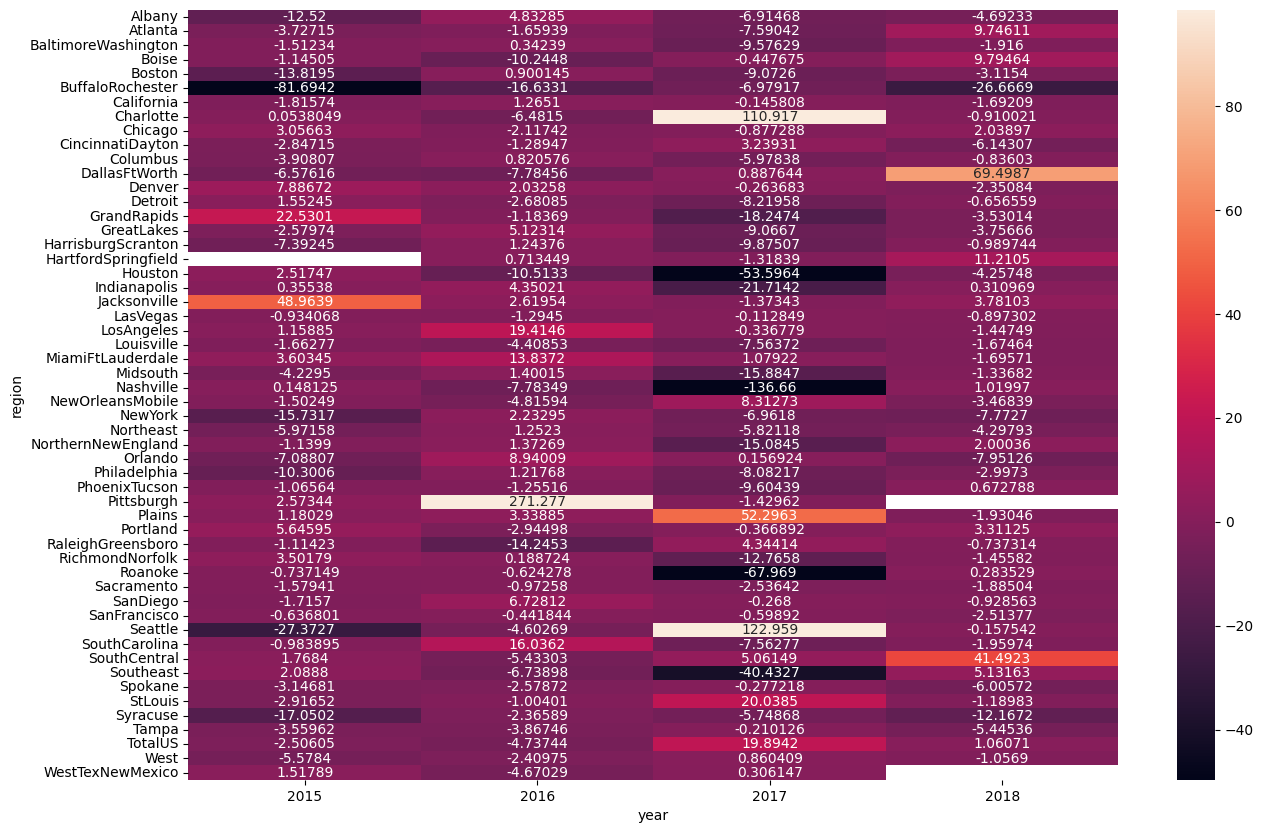

In [4]:
#aguacate organico anual

organic=df_orden.loc[df_orden['type'] == "organic"].reset_index()

val_max_org=organic.loc[organic.groupby(by=["year","region"])["Date"].idxmax()].reset_index()
val_max_org.rename({"Date": "Date_max", "AveragePrice": "Avg_max", "Total Volume":"Total Volume_max"}, inplace=True, axis=1)

val_min_org=organic.loc[organic.groupby(by=["year","region"])["Date"].idxmin()].reset_index()
val_min_org.rename({"Date": "Date_min", "AveragePrice": "Avg_min", "Total Volume":"Total Volume_min"},inplace=True, axis=1)


min_max_org=pd.concat([val_max_org,val_min_con["Date_min"], val_min_org["Avg_min"], val_min_org["Total Volume_min"]], axis=1)


#min_max["Total Volume_max"]==min_max["Total Volume_min"]

min_max_org["Elasticidad"]=((min_max_org["Total Volume_max"]-min_max_org["Total Volume_min"])/min_max_org["Total Volume_min"])/((min_max_org["Avg_max"]-min_max_org["Avg_min"])/min_max_org["Avg_min"])



plt.figure(figsize=(15,10))
heat_min_max_org=min_max_org.pivot(index="region", columns="year", values="Elasticidad")

sns.heatmap(heat_min_max_org, annot=True, fmt="g", robust=True)
plt.show()




Aquí se ve una discrepancia brutal en el año 2017 entre aguacates organicos y convencionales. Mientras los convencionales más o menos mantienen
elasticidad entre [-1,1], lo que quiere decir que pequeños cambios en el precio no influyen demasiado en la demanda; en los organicos, los valores que se tienen para varias regiones tienen valores muy altos. Esto quiere decir que pequeños cambios en el precio influyen muchisimo en la demanda.

Un argumento en contra de este análisis viene de que estamos eligiendo intervalos temporales muy altos. Mientras con los datos que tenemos podemos calcular elasticidades semanales hemos decidido hacer un análisis grueso anual. Esto puede eliminar comportamientos anómalos durante los años analizados pero hemos supuesto que la media es un indicador suficiente para ver comportamientos anómalos. Para poder confirmar esto tendriamos que gacer un análisis en intervalos temporales más pequeños o bien intentar contrastar este análisis con el que han hecho el resto de compañeros.

/tmp/ipykernel_1200/1142275158.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organic_2017_min["Elasticidad"]=((organic_2017_max["Total Volume"]-organic_2017_min["Total Volume"])/organic_2017_min["Total Volume"])/((organic_2017_max["AveragePrice"]-organic_2017_min["AveragePrice"])/organic_2017_min["AveragePrice"])


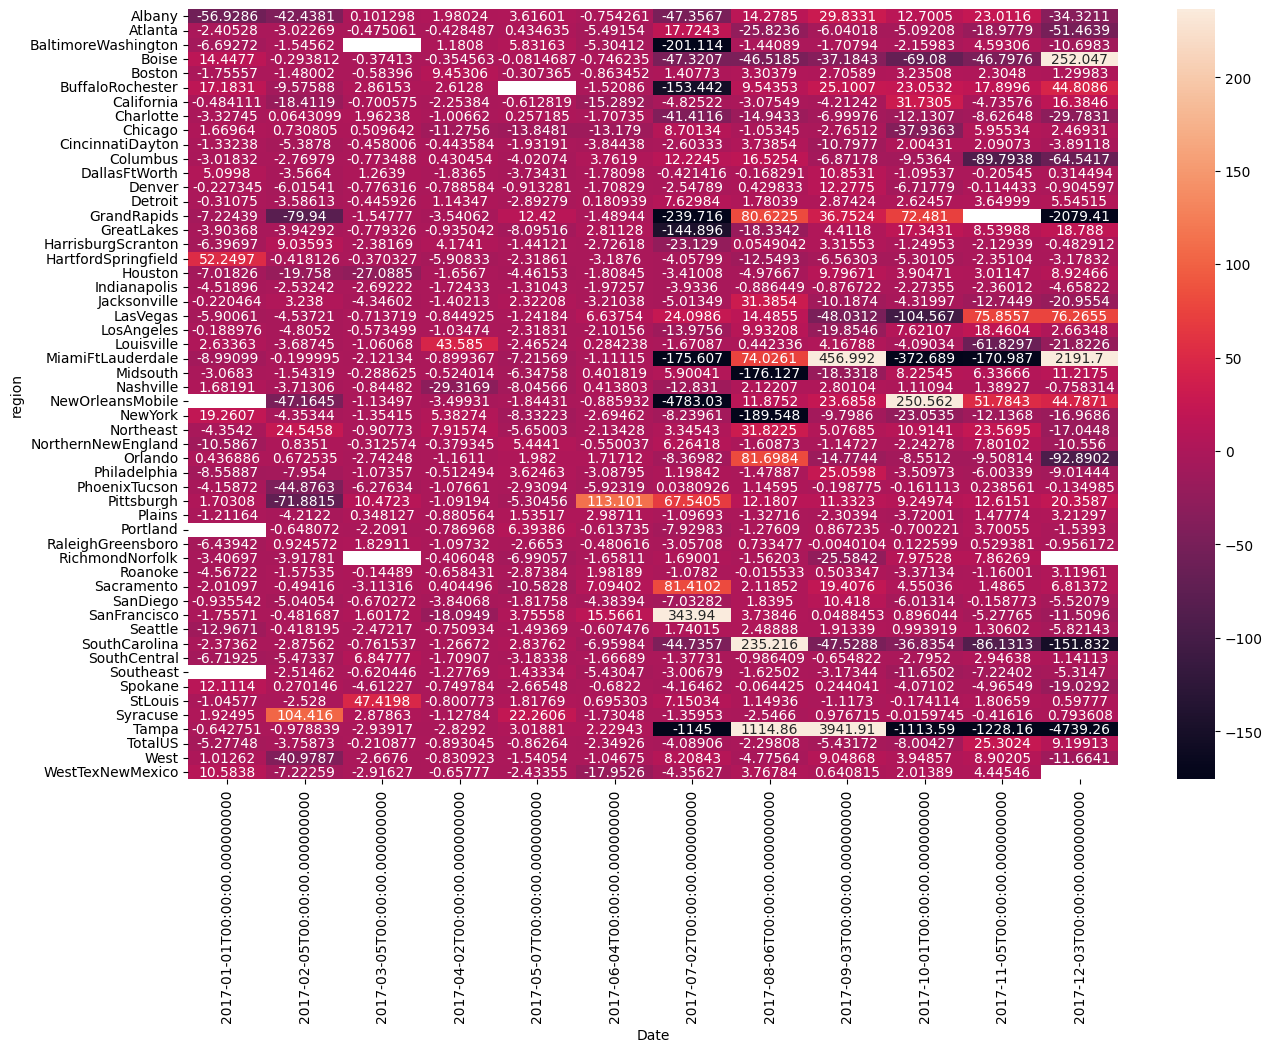

In [51]:
#analizamos la elasticidad por meses para el año 2017 y el aguacate organico

organic_2017= organic.loc[organic['year'] == 2017].reset_index()
organic_2017["Date"]=pd.to_datetime(organic_2017["Date"])


semanal = organic_2017.resample('ME', on='Date').agg({'Date': ['first', 'last']}).reset_index()
semanal=semanal.apply(pd.to_datetime).reset_index()



organic_2017_min=organic_2017[organic_2017["Date"].isin(semanal["Date"]["first"])]
organic_2017_min.reset_index(drop=True, inplace=True)

organic_2017_max=organic_2017[organic_2017["Date"].isin(semanal["Date"]["last"])]
organic_2017_max.reset_index(drop=True, inplace=True)

organic_2017_min["Elasticidad"]=((organic_2017_max["Total Volume"]-organic_2017_min["Total Volume"])/organic_2017_min["Total Volume"])/((organic_2017_max["AveragePrice"]-organic_2017_min["AveragePrice"])/organic_2017_min["AveragePrice"])

plt.figure(figsize=(15,10))
heat_2017=organic_2017_min.pivot(index="region", columns="Date", values="Elasticidad")

sns.heatmap(heat_2017, annot=True, fmt="g", robust=True)

plt.show()


Podemos ver que en julio varias regiones tuvieron una elasticidad negativa muy grande. Esto sugiere que en esta fecha concreta, y para esas regiones, variaciones pequeña del precio movian la demanda de manera inversa. Se podría analizar este mismo mes en otros años para ver si ese patrón continúa o ha sido una casualidad ya que si se repite podría ser una buena fecha para bajar el precio unos centimos el precio del aguacate organico ya que la demanda aumentaría mucho según se ve en la elasticidad. También, a partir de julio, vemos unos valores de elasticidad muy dispares para varias regiones. Por ejemplo, en Tampa, hay valores tanto positivos como negativos de varios miles. Durante la segunda mitad de 2017 la demanda fue mucho más susceptible a variaciones del precio.

Este artículo https://money.cnn.com/2017/09/09/news/economy/avocado-prices-soar/index.html , donde se que el precio del aguacate en 2017 subió un 125% ese año podría explicar la primera mitad del año, donde la elasticidad tiene valores pequeño; es decir, para cambios grandes en el precio, la demanda se mueve en esa misma proporción. Pero parece haber algún evento que, durante el verano, hace que esa variación en el precio sea muchisimo más importante para la demanda. Una posible explicación sería que los precios se estabilziasen, bajaran bastante y en consecuencia mucha gente volvió a coprar en masa al ver esas bajadas de precio. Pero habría que analizar más a fondo para poder llegar a una conclusión.

/tmp/ipykernel_1200/3829066436.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conventional_cuatri_min["Elasticidad"]=((conventional_cuatri_max["Total Volume"]-conventional_cuatri_min["Total Volume"])/conventional_cuatri_min["Total Volume"])/((conventional_cuatri_max["AveragePrice"]-conventional_cuatri_min["AveragePrice"])/conventional_cuatri_min["AveragePrice"])


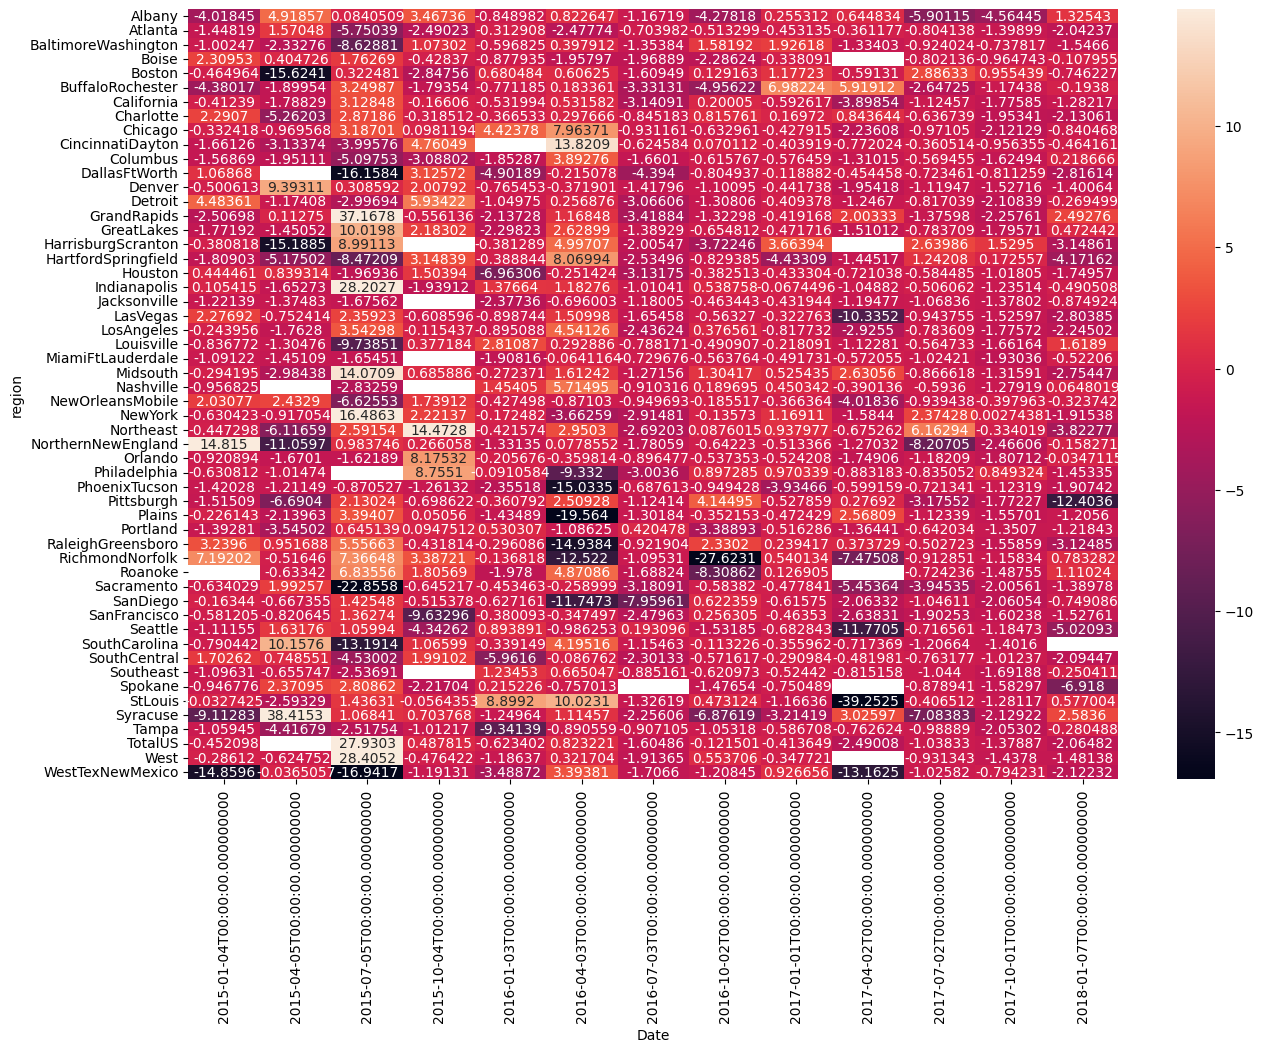

In [65]:
#vamos a probar a hacer el analisis por cuatrimestres y ver si el año 2017 sigue siendo clave

cuatri = conventional.resample('QE', on='Date').agg({'Date': ['first', 'last']}).reset_index()
cuatri=cuatri.apply(pd.to_datetime).reset_index()

conventional_cuatri_min=conventional[conventional["Date"].isin(cuatri["Date"]["first"])]
conventional_cuatri_min.reset_index(drop=True, inplace=True)

conventional_cuatri_max=conventional[conventional["Date"].isin(cuatri["Date"]["last"])]
conventional_cuatri_max.reset_index(drop=True, inplace=True)

conventional_cuatri_min["Elasticidad"]=((conventional_cuatri_max["Total Volume"]-conventional_cuatri_min["Total Volume"])/conventional_cuatri_min["Total Volume"])/((conventional_cuatri_max["AveragePrice"]-conventional_cuatri_min["AveragePrice"])/conventional_cuatri_min["AveragePrice"])

plt.figure(figsize=(15,10))
heat_cuatri_conv=conventional_cuatri_min.pivot(index="region", columns="Date", values="Elasticidad")

sns.heatmap(heat_cuatri_conv, annot=True, fmt="g", robust=True)

plt.show()

vamos a probar ahora con los que nos interesa, que es el aguacate organico. Aunque no está mal comparar estos datos con los que obtuvimos de manera anual. Vemos como en este caso, en el verano de 2015 tenemos los mayores valores de elasticidad, lo que puede comprobarse en la grafica anual y vemos que coincide. Parece que el verano de 2015 también fue una época de elasticidad muy alta para el aguacate convencional, aunque no llega a los valores del orgánico.

/tmp/ipykernel_1200/2087957848.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organic_cuatri_min["Elasticidad"]=((organic_cuatri_max["Total Volume"]-organic_cuatri_min["Total Volume"])/organic_cuatri_min["Total Volume"])/((organic_cuatri_max["AveragePrice"]-organic_cuatri_min["AveragePrice"])/organic_cuatri_min["AveragePrice"])


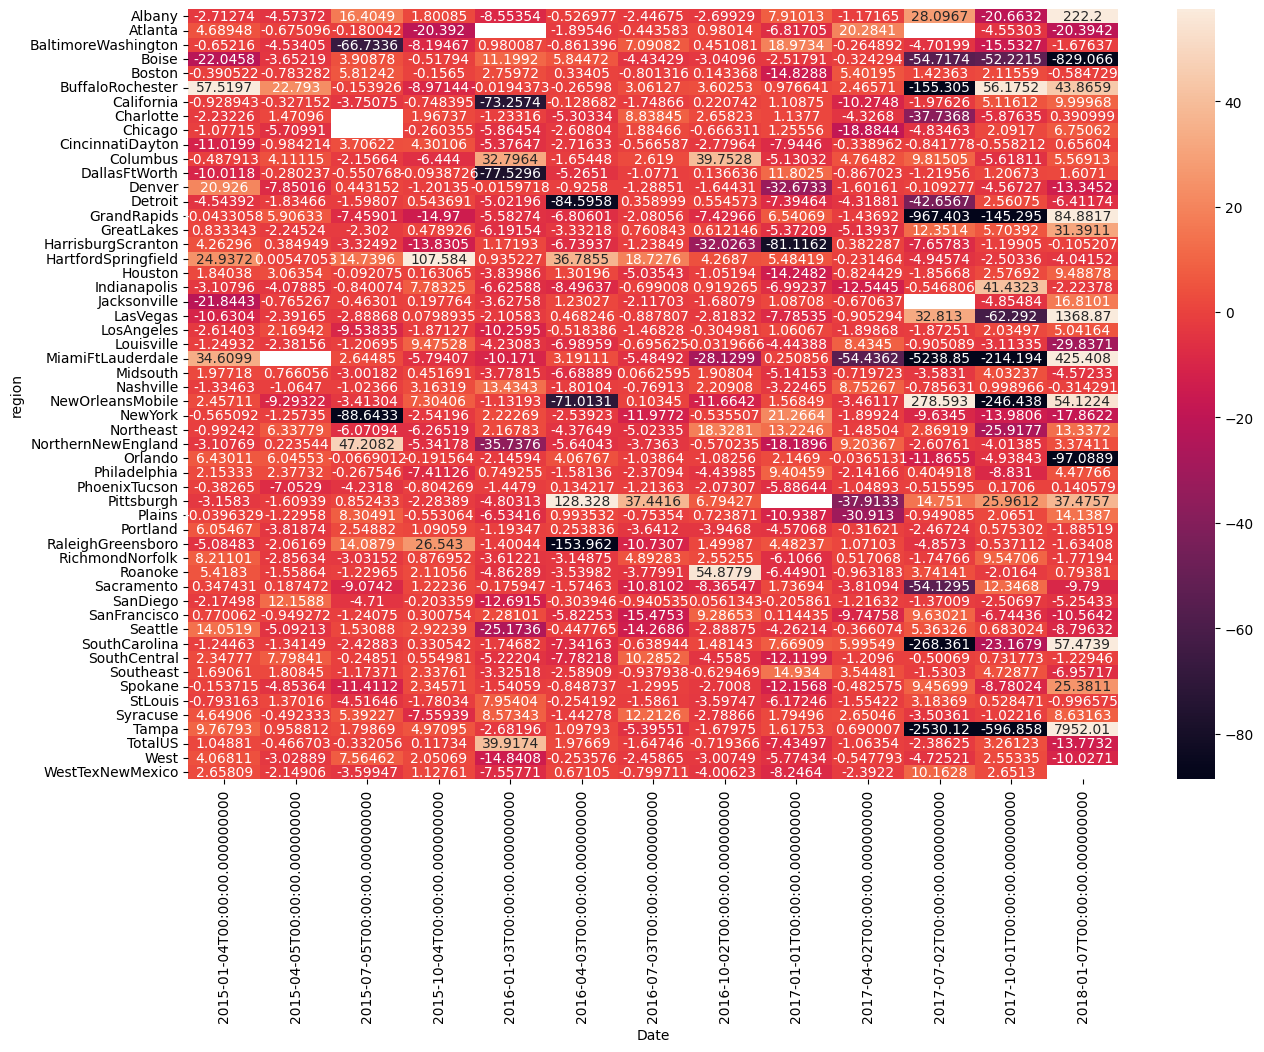

In [66]:
cuatri_org = organic.resample('QE', on='Date').agg({'Date': ['first', 'last']}).reset_index()
cuatri_org=cuatri_org.apply(pd.to_datetime).reset_index()

organic_cuatri_min=organic[organic["Date"].isin(cuatri_org["Date"]["first"])]
organic_cuatri_min.reset_index(drop=True, inplace=True)

organic_cuatri_max=organic[organic["Date"].isin(cuatri_org["Date"]["last"])]
organic_cuatri_max.reset_index(drop=True, inplace=True)

organic_cuatri_min["Elasticidad"]=((organic_cuatri_max["Total Volume"]-organic_cuatri_min["Total Volume"])/organic_cuatri_min["Total Volume"])/((organic_cuatri_max["AveragePrice"]-organic_cuatri_min["AveragePrice"])/organic_cuatri_min["AveragePrice"])

plt.figure(figsize=(15,10))
heat_cuatri_org=organic_cuatri_min.pivot(index="region", columns="Date", values="Elasticidad")

sns.heatmap(heat_cuatri_org, annot=True, fmt="g", robust=True)

plt.show()

Aquí podemos confirmar que los valores más altos de elasticidad los obtenemos de la segunda mitad de 2017, tal y como podíamos ver en el análisis mensual de 2017. Esto no hace más que confirmar que vamos por buen camino al hacer este análisis.